# Training and analyzing bag-of-words models

This notebook allows for training bag-of-words models on the datasets we use, for comparison to the RNN solutions.

In [26]:
import renn
from renn.losses import multiclass_xent

import jax
from jax.experimental import stax, optimizers
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from src import data

from data_processing import analysis_utils as au

In [2]:
cd ..

/usr/local/google/home/ramasesh/Projects/rnn_dynamics


## Load dataset

In [3]:
DATASET = 'ag_news'

dataset_configs = {'dbpedia': {'dataset': 'dbpedia',
                               'max_pad': 400,
                               'batch_size': 256,
                               'num_classes': 14},
                   'yelp':    {'dataset': 'yelp',
                               'max_pad': 800,
                               'batch_size': 256,
                               'num_classes': 5},
                   'ag_news': {'dataset': 'ag_news',
                               'max_pad': 160,
                               'num_classes': 4,
                               'batch_size': 256}}

In [4]:
vocab_size, train_dset, test_dset = data.get_dataset(dataset_configs[DATASET])

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


## Build model

In [5]:
EMBEDDING_DIMENSION=32
VOCAB_SIZE=vocab_size
NUM_CLASSES=dataset_configs[DATASET]['num_classes']

In [6]:
def SequenceSum():
    def init_fun(_, input_shape):
        return (input_shape[0], input_shape[2]), ()
    def apply_fun(_, inputs, **kwargs):
        return jnp.sum(inputs, axis=1)
    return init_fun, apply_fun

In [7]:
input_shape = (-1, dataset_configs[DATASET]['max_pad'])

# Linear model
init_fun, apply_fun = stax.serial(
    renn.embedding(VOCAB_SIZE, EMBEDDING_DIMENSION),
    SequenceSum(),
    stax.Dense(NUM_CLASSES),
    )



### Loss and Accuracy functions

In [8]:
# Loss
def xent(params, batch):
    logits = apply_fun(params, batch['inputs'])
    data_loss = multiclass_xent(logits, batch['labels'])
    return data_loss

f_df = jax.value_and_grad(xent)

# Accuracy
@jax.jit
def accuracy(params, batch):
    logits = apply_fun(params, batch['inputs'])
    predictions = jnp.argmax(logits, axis=1)
    return jnp.mean(predictions == batch['labels'])

## Training

In [9]:
NUM_EPOCHS=3

### Initialize model

In [10]:
# Initialize
key = jax.random.PRNGKey(0)
output_shape, initial_params = init_fun(key, input_shape)

# Set the embedding to 0 for 0
emb = initial_params[0]
new_emb = np.array(emb)
new_emb[0] = np.zeros(EMBEDDING_DIMENSION)
initial_params = [jnp.array(new_emb), *initial_params[1:]]

### Train

In [11]:
learning_rate = optimizers.exponential_decay(2e-3, 1000, 0.8)
init_opt, update_opt, get_params = optimizers.adam(learning_rate)

state = init_opt(initial_params)
losses = []

@jax.jit
def step(k, opt_state, batch):
    params = get_params(opt_state)
    loss, gradients = f_df(params, batch)
    new_state = update_opt(k, gradients, opt_state)
    return new_state, loss

def test_acc(params):
    return jnp.array([accuracy(params, batch) for batch in tfds.as_numpy(test_dset)])

In [16]:
for epoch in range(NUM_EPOCHS):
    print('=====================================')
    print(f'== Epoch #{epoch}')
    p = get_params(state)
    acc = np.mean(test_acc(p))
    print(f'== Test accuracy: {100. * acc:0.2f}%')
    print('=====================================')
    
    for batch in tfds.as_numpy(train_dset):
        k = len(losses)
        state, loss = step(k, state, batch)
        losses.append(loss)

        if k % 100 == 0:
            p = get_params(state)
            print(f'[step {k}]\tLoss: {np.mean(losses[k-100:k]):0.4f}', flush=True)
            
print('=====================================')
print(f'== Epoch #{epoch}')
p = get_params(state)
acc = np.mean(test_acc(p))
print(f'== Test accuracy: {100. * acc:0.2f}%')
print('=====================================')

== Epoch #0
== Test accuracy: 24.24%
[step 0]	Loss: nan


/usr/local/google/home/ramasesh/Projects/rnn_dynamics/env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/google/home/ramasesh/Projects/rnn_dynamics/env/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[step 100]	Loss: 0.6000
[step 200]	Loss: 0.3233
[step 300]	Loss: 0.2962
[step 400]	Loss: 0.2821
== Epoch #1
== Test accuracy: 89.94%
[step 500]	Loss: 0.2678
[step 600]	Loss: 0.1867
[step 700]	Loss: 0.1779
[step 800]	Loss: 0.1699
[step 900]	Loss: 0.1806
== Epoch #2
== Test accuracy: 90.44%
[step 1000]	Loss: 0.1610
[step 1100]	Loss: 0.1299
[step 1200]	Loss: 0.1343
[step 1300]	Loss: 0.1264
[step 1400]	Loss: 0.1278
== Epoch #2
== Test accuracy: 89.83%


## Analyze

Here we get the effective dimensionality of the bag-of-words models, by accumulating the logit changes which are induced by particular words and then 

In [17]:
params = get_params(state)

In [18]:
def delta_logit(vocab_index, params):
    """Returns the changes in bag-of-words logit values induced
    by the word 'vocab_index' """
    test_batch = jnp.zeros((2, 160), dtype = jnp.int64)
    test_batch = jax.ops.index_update(test_batch, jax.ops.index[1,0], vocab_index)
    
    logits = apply_fun(params, test_batch)
    return logits[1] - logits[0]

In [19]:
num_words = 300

In [20]:
most_common_words = np.arange(num_words).reshape(1,-1).T
output_logits = {'initial': apply_fun(initial_params, most_common_words),
                 'final': apply_fun(p, most_common_words)}

In [21]:
f = lambda x: x[1:] - x[0]
logit_changes = {k: f(v) for k,v in output_logits.items()}

In [23]:
PCA_obj = {k: au.PCA_rnn() for k in output_logits.keys()}

for k in output_logits.keys():
    PCA_obj[k].fit(logit_changes[k])

In [24]:
dimensionalities = {k: au.cumulative_var_explained(PCA_obj[k]) for k in PCA_obj.keys()}

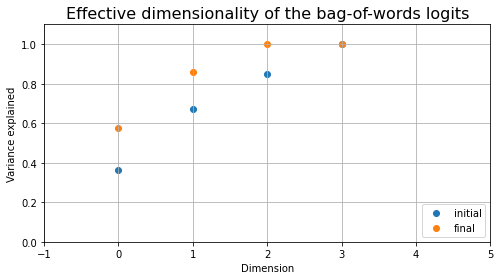

In [29]:
f = au.plot_varexp(dimensionalities)
plt.xlim(-1,5)
plt.title("Effective dimensionality of the bag-of-words logits", fontsize=16);